## Эксперименты с моделями

### Импорт зависимостей

**Загрузка библиотек**

In [1]:
import pandas as pd
import numpy as np

In [2]:
import nltk
from nltk import pos_tag, ngrams
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from html import unescape

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/vladkopchev/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vladkopchev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/vladkopchev/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/vladkopchev/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

In [6]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [7]:
from sklearn.model_selection import cross_validate

In [8]:
from sklearn.neighbors import KNeighborsClassifier

In [9]:
from sklearn.model_selection import GridSearchCV

In [10]:
from sklearn.linear_model import LogisticRegression

In [26]:
from sklearn.metrics import accuracy_score

In [113]:
from sklearn.model_selection import cross_val_score

In [114]:
from sklearn.metrics import roc_auc_score

In [115]:
import optuna, catboost

/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Определяем функции, которые нам понадобятся в экспериментах**

In [11]:
def prettify_scores(scores_dict, model_name):
    mean_scores = pd.DataFrame(scores_dict).iloc[:,2:].mean(axis=0)
    return pd.DataFrame(
        data=mean_scores.values.reshape(1, -1), 
        columns=['Precision', 'Recall', 'F1', 'ROC-AUC'], 
        index=[model_name]
    )

In [12]:
def return_best_param(cv_dict, param_name):
    cv_df = pd.DataFrame(cv_dict).loc[:, [f'param_{param_name}', 'mean_test_score', 'mean_train_score']]
    cv_df['roc_auc_diff'] = np.abs(cv_df.mean_train_score - cv_df.mean_test_score)
    return cv_df.query('roc_auc_diff < 0.11').sort_values('mean_test_score')[f'param_{param_name}'].iloc[-1]

In [95]:
def return_best_params(cv_dict, param1_name, param2_name):
    res_df = pd.DataFrame(
        cv_dict
    ).loc[:, [f'param_{"max_depth"}', f'param_{"min_samples_split"}', 'mean_train_score', 'mean_test_score']]
    res_df['roc_auc_diff'] = np.abs(res_df.mean_train_score - res_df.mean_test_score)
    return res_df.query(
        'roc_auc_diff < 0.11'
    ).sort_values(
        'mean_test_score'
    ).iloc[-1].loc[[f'param_{"max_depth"}', f'param_{"min_samples_split"}']].values.tolist()

**Зарузка данных**

In [13]:
df = pd.read_parquet(
    'elon_musk_tweets_labeled.parquet'
).drop(
    [
        'id', 
        'hashtags', 
        'user_name', 
        'user_created', 
        'is_retweet', 
        'date'
    ], 
    axis=1
)  # Файл формируется в ноутбуке preprocessing

**Предварительная обработка данных**

In [14]:
df = pd.get_dummies(
    df, 
    columns=['user_location', 'user_description', 'user_verified', 'source'], 
    drop_first=True, 
    dtype=int
)

Очистка:

In [15]:
df['text'] = df['text'].apply(unescape)

In [16]:
HTML_symbols_check = ['&quot;', '&amp;', '&lt', '&gt;', '&apos;', '&#39;'] #Проверяем, что HTML-cущности заменены на соответствующие символы

for symbol in HTML_symbols_check:
    if df['text'].str.contains(symbol).any():
        print(f"Символ '{symbol}' найден в датасете.")
    else:
        print(f"Символ '{symbol}' не найден в датасете.")

Символ '&quot;' не найден в датасете.
Символ '&amp;' не найден в датасете.
Символ '&lt' не найден в датасете.
Символ '&gt;' не найден в датасете.
Символ '&apos;' не найден в датасете.
Символ '&#39;' не найден в датасете.


In [17]:
df['text'] = df['text'].str.replace(r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', '', regex=True) #Удаляем emails
df['text'] = df['text'].str.replace(r'@([A-Za-z0-9_]{1,})', '', regex=True) #Удаляем ники
df['text'] = df['text'].str.replace(r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})', '', regex=True) #Удаляем urls

df['text'] = df['text'].str.lower()
df['text'] = df['text'].str.replace(r'[^a-zA-Z\s]', '', regex=True) #Удаляем знаки препинания и цифры и оставляем только буквы и пробелы
df['text'] = df['text'].str.replace(r'\s+', ' ', regex=True).str.strip()  #Удаляем лишние пробелы

Токенизация:

In [18]:
df['tokens'] = df['text'].apply(word_tokenize)

Удаление стоп-слов:

In [19]:
def delete_stopwords(tokens):
    cleaned = []
    for word in tokens:
        if word not in stop_words:
            cleaned.append(word)
    return cleaned

df['cleaned_tokens'] = df['tokens'].apply(delete_stopwords)

Лемматизация:

In [20]:
lemmatizer = WordNetLemmatizer()

In [21]:
def lemmatize_tokens(tokens):
    lemmatized = []
    for word in tokens:
        lemmatized.append(lemmatizer.lemmatize(word))
    return lemmatized

df['lemmatized'] = df['cleaned_tokens'].apply(lemmatize_tokens)

In [22]:
df['lemmatized'] = df['lemmatized'].apply(' '.join)

In [23]:
df.drop(['text', 'tokens', 'cleaned_tokens'], axis=1, inplace=True)

### Простые правила

**Формируем $X, y$**

In [24]:
X = df.lemmatized  # Еще нужно достать оттуда какое-то векторное представление
y = df.feeling_auto  # Куда делся df.lemmatized??
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

**Рандом**

In [27]:
y_pred = np.random.randint(low=0, high=1, size=y_test.shape[0])
accuracy_score(y_test, y_pred)

0.38261851015801357

**Простые правила**

In [28]:
def rule_predict(x):
    return ~x.str.contains('(bad|sad)', regex=True)

In [29]:
y_pred = rule_predict(X_test)

/var/folders/0k/pk7zyw6x2sqcjpbqvgf0ssh80000gn/T/ipykernel_67362/819608852.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  return ~x.str.contains('(bad|sad)', regex=True)


In [30]:
accuracy_score(y_test, y_pred)

0.6224604966139955

**Словарный подход**

In [31]:
!file -I ./opinion-lexicon-English/negative-words.txt | sed 's/.*charset=//g'

iso-8859-1


In [32]:
with open('./opinion-lexicon-English/negative-words.txt', 'r', encoding='iso-8859-1') as f:
    neg = f.read()

In [33]:
with open('./opinion-lexicon-English/positive-words.txt', 'r', encoding='iso-8859-1') as f:
    pos = f.read()

In [34]:
pos = pos.split('\n')[31:]
neg = neg.split('\n')[31:]

In [35]:
sentiment_dict = {**{w: 1 for w in pos}, **{w: -1 for w in neg}}

In [63]:
def get_dict_scores(tweets):
    return np.array(list(map(lambda x : sentiment_dict.get(x, 0), tweets)))

In [64]:
def get_prediction(X, proba_func):
    return X.str.split().apply(lambda lst : proba_func(get_dict_scores(lst))).fillna(0.5)

In [68]:
y_pred = get_prediction(X_test, lambda scores : np.mean(scores) > 0.5)  # simple mean

/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [73]:
y_pred = get_prediction(
    X_test, 
    lambda scores : ((scores.sum() - (1 - scores).sum()) / ((scores.sum() + (1 - scores).sum()))) > 0.5
)  # relative proportion

/var/folders/0k/pk7zyw6x2sqcjpbqvgf0ssh80000gn/T/ipykernel_67362/2307301785.py:3: RuntimeWarning: invalid value encountered in scalar divide
  lambda scores : ((scores.sum() - (1 - scores).sum()) / ((scores.sum() + (1 - scores).sum()))) > 0.5


In [74]:
y_pred = get_prediction(
    X_test, 
    lambda scores : np.log(np.sum(scores[scores == 1]) + 0.5) - np.log(np.sum(scores[scores == 0]) + 0.5) > 0.5
)  # logit

In [75]:
accuracy_score(y_test, y_pred)

0.5744920993227991

### Простые модели, BoW

Логично сравнивать не как модели ведут себя на базовых параметрах, а какого максимума они способны достичь. Ищем гиперпараметры, при которых модель лучше всего оценивает вероятности. Чтобы исключить переобучение, будем смотреть только на параметры, где разница в средних `ROC-AUC` на трейне и тесте не больше 10%.

**Формируем $X, y$**

Для начала подберем оптимальное количество фичей для `BoW`. Для этого замерим метрику `ROC-AUC` для простейшей модели (Наивный Байес), обученной только на векторных представлениях, и посмотрим, после какого значения добавления новых фичей уже практически не улучшает оценку вероятностей этой моделью.

In [76]:
%%time

param_vals = list(range(1, 3000, 50))
metric_vals = []

for param_max_features in param_vals:
    vectorizer = CountVectorizer(max_features=param_max_features)
    tweets_bow = vectorizer.fit_transform(df['lemmatized'])
    
    tweets_bow = pd.DataFrame(
        data=tweets_bow.toarray(), 
        columns=vectorizer.get_feature_names_out()
    )
    
    X = tweets_bow
    y = df.feeling_auto

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    clf = MultinomialNB()
    clf.fit(X_train, y_train)
    metric_vals.append(roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))

CPU times: user 24.4 s, sys: 33.9 s, total: 58.3 s
Wall time: 7.74 s


Видим, что график `ROC-AUC` стабилизируется примерно после `x=700` примерно на уровне `y=0.8` Поэтому выберем `max_features=700`.

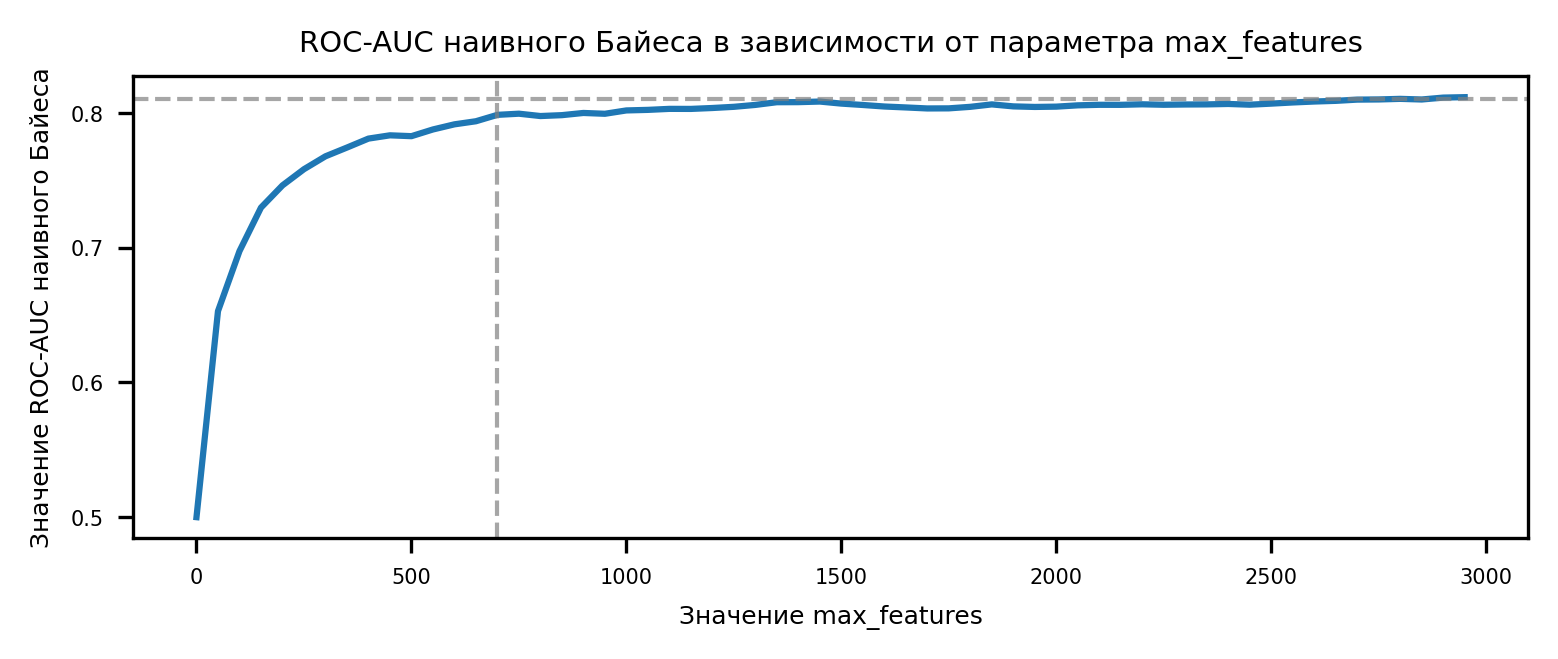

In [77]:
plt.figure(figsize=(6, 2), dpi=300)
plt.plot(param_vals, metric_vals)

plt.title('ROC-AUC наивного Байеса в зависимости от параметра max_features', fontsize=7)
plt.xlabel('Значение max_features', fontsize=6)
plt.ylabel('Значение ROC-AUC наивного Байеса', fontsize=6)
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
plt.axvline(x=700, linestyle='--', c='grey', alpha=0.7, linewidth=1)
plt.axhline(y=0.81, linestyle='--', c='grey', alpha=0.7, linewidth=1)

Теперь создадим итоговый `X`, который будет содержать оптимальные `BoW`-представления + остальные фичи из датасета.

In [78]:
vectorizer = CountVectorizer(max_features=700)
tweets_bow = vectorizer.fit_transform(df['lemmatized'])

tweets_bow = pd.DataFrame(
    data=tweets_bow.toarray(), 
    columns=vectorizer.get_feature_names_out()
)

X = pd.concat([df, tweets_bow], axis=1).drop(['feeling_auto', 'lemmatized'], axis=1)
y = df.feeling_auto

In [79]:
simple_metric_vals = []

**BoW + Наивный Байес**

[Описание](https://scikit-learn.org/1.5/modules/naive_bayes.html)

In [80]:
%%time

gnb = GaussianNB()

simple_metric_vals.append(
    prettify_scores(
        scores_dict=cross_validate(
            estimator=gnb,
            X=X,
            y=y,
            scoring=['precision', 'recall', 'f1', 'roc_auc'],
            cv=10
        ),
        model_name='Наивный Байес + BoW'
    )
)

CPU times: user 347 ms, sys: 117 ms, total: 464 ms
Wall time: 464 ms


**BoW + $k$ ближайших соседей**

In [81]:
knn = KNeighborsClassifier()

Найдем оптимальные гиперпараметры:

In [82]:
%%time

grid_search_res = GridSearchCV(
    estimator=knn,
    param_grid={'n_neighbors': range(500, 1500, 50)},
    scoring='roc_auc',
    cv=10,
    return_train_score=True
).fit(X, y)

CPU times: user 11min 31s, sys: 6min 14s, total: 17min 45s
Wall time: 3min 17s


Посмотрим на результат:

In [83]:
knn = KNeighborsClassifier(
    n_neighbors=return_best_param(
        grid_search_res.cv_results_, 
        'n_neighbors'
    )
)

In [84]:
%%time

simple_metric_vals.append(
    prettify_scores(
        scores_dict=cross_validate(
            estimator=knn,
            X=X,
            y=y,
            scoring=['precision', 'recall', 'f1', 'roc_auc'],
            cv=10
        ),
        model_name='kNN + BoW'
    )
)

CPU times: user 15.5 s, sys: 10.1 s, total: 25.6 s
Wall time: 3.36 s


**BoW + Логистическая регрессия**

In [85]:
lr = LogisticRegression(max_iter=1000)

In [86]:
%%time

grid_search_res = GridSearchCV(
    estimator=lr,
    param_grid={'C': np.linspace(0.1, 1, 50)},
    scoring='roc_auc',
    cv=10,
    return_train_score=True
).fit(X, y)

CPU times: user 20min 16s, sys: 57 s, total: 21min 13s
Wall time: 2min 45s


In [87]:
lr = LogisticRegression(
    max_iter=1000, 
    C=return_best_param(
        grid_search_res.cv_results_, 
        'C'
    )
)

In [88]:
%%time

simple_metric_vals.append(
    prettify_scores(
        scores_dict=cross_validate(
            estimator=lr,
            X=X,
            y=y,
            scoring=['precision', 'recall', 'f1', 'roc_auc'],
            cv=10
        ),
        model_name='Логистическая регрессия + BoW'
    )
)

CPU times: user 24 s, sys: 1.47 s, total: 25.4 s
Wall time: 3.3 s


**Сравнение**

In [89]:
pd.concat(simple_metric_vals)

,Precision,Recall,F1,ROC-AUC
Наивный Байес + BoW,0.620196,0.981096,0.759797,0.641602
kNN + BoW,0.618395,1.000000,0.764207,0.633953
Логистическая регрессия + BoW,0.622948,0.990414,0.764811,0.618135


### Модели на основе деревьев, BoW

TODO. Сначала только BoW, потом только tf-IDF, чтобы не было проблем с `X`.

**Дерево решений**

**Случайный лес**

TODO. Тут тоже напишу функцию для красивой обработки результатов `grid search`.

Последовательный подбор параметров от маленького к большему.

In [90]:
from sklearn.ensemble import RandomForestClassifier

In [91]:
rf = RandomForestClassifier()

In [92]:
%%time

grid_search_res = GridSearchCV(
    estimator=rf,
    param_grid={
        'max_depth': range(2, 20, 4),
        'min_samples_split': range(2, 20, 4)
    },
    scoring='roc_auc',
    cv=10,
    return_train_score=True
).fit(X, y)

CPU times: user 1min 11s, sys: 2.7 s, total: 1min 13s
Wall time: 1min 13s


In [105]:
best_max_depth, best_min_samples_split = return_best_params(
    grid_search_res.cv_results_, 
    'max_depth', 
    'min_samples_split'
)

rf = RandomForestClassifier(
    max_depth=int(best_max_depth),
    min_samples_split=int(best_min_samples_split)
)

In [106]:
%%time

simple_metric_vals.append(
    prettify_scores(
        scores_dict=cross_validate(
            estimator=rf,
            X=X,
            y=y,
            scoring=['precision', 'recall', 'f1', 'roc_auc'],
            cv=10
        ),
        model_name='Случайный лес + BoW'
    )
)

CPU times: user 1.19 s, sys: 108 ms, total: 1.3 s
Wall time: 1.3 s


In [127]:
pd.concat(simple_metric_vals)

,Precision,Recall,F1,ROC-AUC
Наивный Байес + BoW,0.620196,0.981096,0.759797,0.641602
kNN + BoW,0.618395,1.000000,0.764207,0.633953
Логистическая регрессия + BoW,0.622948,0.990414,0.764811,0.618135
Случайный лес + BoW,0.618395,1.000000,0.764207,0.643349
CatBoostClassifier + BoW,0.665670,0.820037,0.728973,0.685683


**Бустинг, `xgboost`**

TODO. См. ноутбук из `dev`.

**Бустинг, `catboost`**

Продолжим ту же идею для подбора гиперпараметров, но уже с помощью более сложных инструментов, подходящих для перебора большого числа параметров по крупной сeтке.

In [111]:
def pr_diff(clf):
    train_scores = []
    test_scores = []

    for i in range(4):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=0)
        clf.fit(X_train, y_train)
        
        train_score = roc_auc_score(y_train, clf.predict_proba(X_train)[:,1])
        test_score = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

        train_scores.append(train_score)
        test_scores.append(test_score)
    
    return np.abs(np.max(train_scores) - np.min(test_scores))

In [116]:
def objective(trial):
    params = {
        'num_trees': trial.suggest_int('num_trees', 5, 100),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        'verbose': False
    }

    model = catboost.CatBoostClassifier(**params)
    metrics = [np.mean(cross_val_score(model, X=pd.DataFrame(X), y=y, scoring='roc_auc', cv=10)), pr_diff(model)]

    return metrics

In [117]:
study = optuna.create_study(
    directions=['maximize', 'minimize'],
    sampler=optuna.samplers.TPESampler()
)

[I 2024-12-11 14:54:46,215] A new study created in memory with name: no-name-51706545-a103-42b5-beda-63ce53e81d6b


In [38]:
!pip list | grep -e "catboost.*"

553.14s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


catboost           1.2.7


In [118]:
study.optimize(
    func=objective,
    n_trials=10,
    timeout=600,
    show_progress_bar=True,
    gc_after_trial=True
)

  0%|                                                    | 0/10 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x179376a90> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ method, or inherit from `sklearn.base.BaseEstimator` and other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.ClusterMixin`, and `sklearn.base.OutlierMixin`.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x309ced650> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. Th

[I 2024-12-11 14:54:53,041] Trial 0 finished with values: [0.6717285212691234, 0.16568773376911183] and parameters: {'num_trees': 74, 'max_depth': 5, 'min_data_in_leaf': 33}.


/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x30977c490> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ method, or inherit from `sklearn.base.BaseEstimator` and other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.ClusterMixin`, and `sklearn.base.OutlierMixin`.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x30977e550> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ m

[I 2024-12-11 14:54:57,420] Trial 1 finished with values: [0.6347415556322515, 0.1928850213100507] and parameters: {'num_trees': 94, 'max_depth': 7, 'min_data_in_leaf': 65}.


/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x30890f190> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ method, or inherit from `sklearn.base.BaseEstimator` and other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.ClusterMixin`, and `sklearn.base.OutlierMixin`.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x309c34690> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ m

[I 2024-12-11 14:54:59,445] Trial 2 finished with values: [0.6835402927535585, 0.10186155798745022] and parameters: {'num_trees': 75, 'max_depth': 2, 'min_data_in_leaf': 52}.


/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x3089eafd0> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ method, or inherit from `sklearn.base.BaseEstimator` and other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.ClusterMixin`, and `sklearn.base.OutlierMixin`.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x309ac8990> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ m

[I 2024-12-11 14:55:06,952] Trial 3 finished with values: [0.6228874165608784, 0.20284233996045364] and parameters: {'num_trees': 82, 'max_depth': 9, 'min_data_in_leaf': 6}.


/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x308906550> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ method, or inherit from `sklearn.base.BaseEstimator` and other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.ClusterMixin`, and `sklearn.base.OutlierMixin`.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x17a661050> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ m

[I 2024-12-11 14:55:11,573] Trial 4 finished with values: [0.6300608756904021, 0.20863147050292008] and parameters: {'num_trees': 72, 'max_depth': 8, 'min_data_in_leaf': 71}.


/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x308a09b10> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ method, or inherit from `sklearn.base.BaseEstimator` and other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.ClusterMixin`, and `sklearn.base.OutlierMixin`.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x309092210> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ m

[I 2024-12-11 14:55:14,042] Trial 5 finished with values: [0.6215499974937625, 0.16491964685644478] and parameters: {'num_trees': 19, 'max_depth': 9, 'min_data_in_leaf': 33}.


/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x3097b04d0> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ method, or inherit from `sklearn.base.BaseEstimator` and other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.ClusterMixin`, and `sklearn.base.OutlierMixin`.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x308914d90> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ m

[I 2024-12-11 14:55:16,157] Trial 6 finished with values: [0.6659010801993773, 0.11252800535433105] and parameters: {'num_trees': 68, 'max_depth': 3, 'min_data_in_leaf': 3}.


/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x30895eb50> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ method, or inherit from `sklearn.base.BaseEstimator` and other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.ClusterMixin`, and `sklearn.base.OutlierMixin`.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x308849d50> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ m

[I 2024-12-11 14:55:18,628] Trial 7 finished with values: [0.6856826186140352, 0.15741188002601514] and parameters: {'num_trees': 63, 'max_depth': 5, 'min_data_in_leaf': 80}.


/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x309d18050> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ method, or inherit from `sklearn.base.BaseEstimator` and other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.ClusterMixin`, and `sklearn.base.OutlierMixin`.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x30894bb90> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ m

[I 2024-12-11 14:55:19,733] Trial 8 finished with values: [0.6057640051897148, 0.06790246980406855] and parameters: {'num_trees': 13, 'max_depth': 2, 'min_data_in_leaf': 62}.


/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x309429b90> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ method, or inherit from `sklearn.base.BaseEstimator` and other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.ClusterMixin`, and `sklearn.base.OutlierMixin`.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x17a74fd90> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ m

[I 2024-12-11 14:55:23,422] Trial 9 finished with values: [0.6170280836969952, 0.20694601238732524] and parameters: {'num_trees': 53, 'max_depth': 8, 'min_data_in_leaf': 69}.


In [124]:
best_params = study.trials_dataframe().sort_values(
    by=['values_0', 'values_1'], 
    ascending=[False, True]
).iloc[0,-4:-1]

In [125]:
clf = catboost.CatBoostClassifier(
    max_depth=best_params.params_max_depth,
    min_data_in_leaf=best_params.params_min_data_in_leaf,
    num_trees=best_params.params_num_trees
)

In [126]:
%%time

simple_metric_vals.append(
    prettify_scores(
        scores_dict=cross_validate(
            estimator=clf,
            X=X,
            y=y,
            scoring=['precision', 'recall', 'f1', 'roc_auc'],
            cv=10
        ),
        model_name='CatBoostClassifier + BoW'
    )
)

/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x3096eb690> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ method, or inherit from `sklearn.base.BaseEstimator` and other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.ClusterMixin`, and `sklearn.base.OutlierMixin`.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x309b98150> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ m

Learning rate set to 0.265252
0:	learn: 0.6709255	total: 2.48ms	remaining: 154ms
1:	learn: 0.6606977	total: 4.69ms	remaining: 143ms
2:	learn: 0.6495082	total: 6.79ms	remaining: 136ms
3:	learn: 0.6429773	total: 8.82ms	remaining: 130ms
4:	learn: 0.6364207	total: 10.8ms	remaining: 125ms
5:	learn: 0.6310108	total: 12.7ms	remaining: 121ms
6:	learn: 0.6224481	total: 14.6ms	remaining: 117ms
7:	learn: 0.6187068	total: 16.6ms	remaining: 114ms
8:	learn: 0.6148154	total: 18.3ms	remaining: 110ms
9:	learn: 0.6107604	total: 20ms	remaining: 106ms
10:	learn: 0.6083835	total: 21.7ms	remaining: 103ms
11:	learn: 0.6046975	total: 23.5ms	remaining: 99.9ms
12:	learn: 0.6021614	total: 25.3ms	remaining: 97.5ms
13:	learn: 0.5987087	total: 27.1ms	remaining: 94.8ms
14:	learn: 0.5945926	total: 28.9ms	remaining: 92.3ms
15:	learn: 0.5902784	total: 30.7ms	remaining: 90.2ms
16:	learn: 0.5877909	total: 32.5ms	remaining: 87.8ms
17:	learn: 0.5846497	total: 34.2ms	remaining: 85.5ms
18:	learn: 0.5834104	total: 36ms	remain

/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x309b98150> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ method, or inherit from `sklearn.base.BaseEstimator` and other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.ClusterMixin`, and `sklearn.base.OutlierMixin`.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x309b98150> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ m

9:	learn: 0.6112355	total: 19.4ms	remaining: 103ms
10:	learn: 0.6072927	total: 21.3ms	remaining: 101ms
11:	learn: 0.6043487	total: 23.2ms	remaining: 98.4ms
12:	learn: 0.6016603	total: 25.1ms	remaining: 96.4ms
13:	learn: 0.5984025	total: 27ms	remaining: 94.6ms
14:	learn: 0.5957701	total: 29.2ms	remaining: 93.5ms
15:	learn: 0.5933201	total: 31.7ms	remaining: 93ms
16:	learn: 0.5907126	total: 34.2ms	remaining: 92.6ms
17:	learn: 0.5885074	total: 36.2ms	remaining: 90.6ms
18:	learn: 0.5853905	total: 38.2ms	remaining: 88.6ms
19:	learn: 0.5828409	total: 40.3ms	remaining: 86.6ms
20:	learn: 0.5813769	total: 42.1ms	remaining: 84.2ms
21:	learn: 0.5792226	total: 44.1ms	remaining: 82.2ms
22:	learn: 0.5774900	total: 46ms	remaining: 79.9ms
23:	learn: 0.5746745	total: 48ms	remaining: 78.1ms
24:	learn: 0.5725147	total: 50.1ms	remaining: 76.1ms
25:	learn: 0.5700783	total: 51.9ms	remaining: 73.8ms
26:	learn: 0.5684962	total: 53.8ms	remaining: 71.7ms
27:	learn: 0.5666059	total: 55.8ms	remaining: 69.8ms
28:	

/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x309cf4890> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ method, or inherit from `sklearn.base.BaseEstimator` and other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.ClusterMixin`, and `sklearn.base.OutlierMixin`.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x309cf4890> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ m

23:	learn: 0.5756842	total: 43.3ms	remaining: 70.4ms
24:	learn: 0.5732617	total: 45.1ms	remaining: 68.5ms
25:	learn: 0.5717969	total: 46.9ms	remaining: 66.7ms
26:	learn: 0.5699897	total: 48.6ms	remaining: 64.8ms
27:	learn: 0.5687982	total: 50.3ms	remaining: 62.9ms
28:	learn: 0.5665991	total: 52.1ms	remaining: 61.1ms
29:	learn: 0.5650433	total: 53.9ms	remaining: 59.3ms
30:	learn: 0.5630240	total: 55.7ms	remaining: 57.5ms
31:	learn: 0.5607553	total: 57.5ms	remaining: 55.7ms
32:	learn: 0.5580244	total: 59.3ms	remaining: 53.9ms
33:	learn: 0.5559631	total: 61.2ms	remaining: 52.2ms
34:	learn: 0.5538217	total: 63.5ms	remaining: 50.8ms
35:	learn: 0.5518755	total: 65.6ms	remaining: 49.2ms
36:	learn: 0.5501591	total: 67.4ms	remaining: 47.3ms
37:	learn: 0.5475445	total: 69.1ms	remaining: 45.5ms
38:	learn: 0.5448119	total: 71ms	remaining: 43.7ms
39:	learn: 0.5424945	total: 72.9ms	remaining: 41.9ms
40:	learn: 0.5407114	total: 74.6ms	remaining: 40ms
41:	learn: 0.5384197	total: 76.5ms	remaining: 38.2

/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x309b5a110> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ method, or inherit from `sklearn.base.BaseEstimator` and other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.ClusterMixin`, and `sklearn.base.OutlierMixin`.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x309b5a110> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ m

39:	learn: 0.5423411	total: 77.4ms	remaining: 44.5ms
40:	learn: 0.5380421	total: 79.5ms	remaining: 42.6ms
41:	learn: 0.5363723	total: 81.4ms	remaining: 40.7ms
42:	learn: 0.5349401	total: 83.3ms	remaining: 38.8ms
43:	learn: 0.5323844	total: 85.3ms	remaining: 36.8ms
44:	learn: 0.5308629	total: 87.2ms	remaining: 34.9ms
45:	learn: 0.5289463	total: 89.2ms	remaining: 33ms
46:	learn: 0.5269265	total: 91.4ms	remaining: 31.1ms
47:	learn: 0.5257739	total: 93.7ms	remaining: 29.3ms
48:	learn: 0.5237675	total: 95.7ms	remaining: 27.3ms
49:	learn: 0.5224605	total: 97.6ms	remaining: 25.4ms
50:	learn: 0.5210176	total: 99.4ms	remaining: 23.4ms
51:	learn: 0.5190145	total: 102ms	remaining: 21.5ms
52:	learn: 0.5166303	total: 104ms	remaining: 19.6ms
53:	learn: 0.5151939	total: 106ms	remaining: 17.6ms
54:	learn: 0.5136644	total: 108ms	remaining: 15.7ms
55:	learn: 0.5125681	total: 110ms	remaining: 13.7ms
56:	learn: 0.5106523	total: 112ms	remaining: 11.7ms
57:	learn: 0.5089583	total: 113ms	remaining: 9.77ms
58

/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x309b2bb10> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ method, or inherit from `sklearn.base.BaseEstimator` and other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.ClusterMixin`, and `sklearn.base.OutlierMixin`.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x309b2bb10> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ m

49:	learn: 0.5135330	total: 91.1ms	remaining: 23.7ms
50:	learn: 0.5114627	total: 92.9ms	remaining: 21.9ms
51:	learn: 0.5100422	total: 94.6ms	remaining: 20ms
52:	learn: 0.5086446	total: 96.4ms	remaining: 18.2ms
53:	learn: 0.5070521	total: 98.1ms	remaining: 16.4ms
54:	learn: 0.5045762	total: 100ms	remaining: 14.6ms
55:	learn: 0.5033773	total: 102ms	remaining: 12.8ms
56:	learn: 0.5019562	total: 104ms	remaining: 11ms
57:	learn: 0.4997889	total: 106ms	remaining: 9.16ms
58:	learn: 0.4983811	total: 109ms	remaining: 7.36ms
59:	learn: 0.4966864	total: 111ms	remaining: 5.56ms
60:	learn: 0.4884306	total: 113ms	remaining: 3.71ms
61:	learn: 0.4867499	total: 115ms	remaining: 1.85ms
62:	learn: 0.4842729	total: 117ms	remaining: 0us
Learning rate set to 0.265273
0:	learn: 0.6723616	total: 2.4ms	remaining: 149ms
1:	learn: 0.6580386	total: 4.25ms	remaining: 130ms
2:	learn: 0.6444297	total: 6.16ms	remaining: 123ms
3:	learn: 0.6390720	total: 8.11ms	remaining: 120ms
4:	learn: 0.6341224	total: 9.96ms	remaini

/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x30a6d4590> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ method, or inherit from `sklearn.base.BaseEstimator` and other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.ClusterMixin`, and `sklearn.base.OutlierMixin`.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/course-work-venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:322: FutureWarning: Estimator <catboost.core.CatBoostClassifier object at 0x30a6d4590> has no __sklearn_tags__ attribute, which is defined in `sklearn.base.BaseEstimator`. This will raise an error in scikit-learn 1.8. Please define the __sklearn_tags__ m

### Простые модели, tf-IDF

In [ ]:
pass

In [ ]:
for max_features in range(3000, 50):
    tfidf_vectorizer = TfidfVectorizer(max_features=100)
    X = tfidf_vectorizer.fit_transform(X).toarray()

In [ ]:
for max_features in range(0, 3000, 50):
    tfidf_vectorizer = TfidfVectorizer(max_features=100)
    X = tfidf_vectorizer.fit_transform(X).toarray()

### Модели на основе деревьев, tf-IDF